In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/yossiarviv/Desktop/Datasets/Food_Products_Value.csv', 
                 index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df

,U11STI
DATE,
1992-01-01,26169.0
1992-02-01,25992.0
1992-03-01,25367.0
1992-04-01,24766.0
1992-05-01,24749.0
...,...
2018-10-01,56732.0
2018-11-01,55272.0
2018-12-01,53313.0


In [3]:
df.rename({'U11STI':'Product Sales'},axis=1,inplace=True)
df

,Product Sales
DATE,
1992-01-01,26169.0
1992-02-01,25992.0
1992-03-01,25367.0
1992-04-01,24766.0
1992-05-01,24749.0
...,...
2018-10-01,56732.0
2018-11-01,55272.0
2018-12-01,53313.0


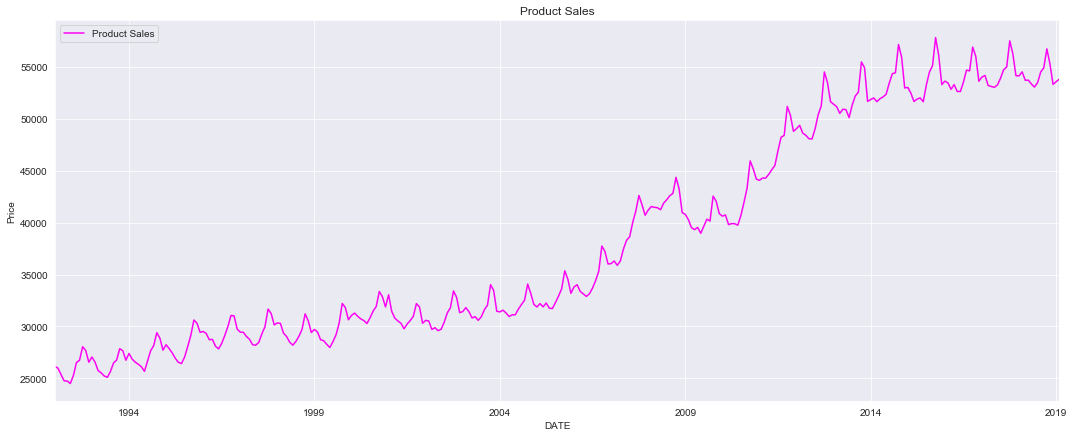

In [4]:
df.plot(figsize=(18,7),legend=True,color='#fc03f4')
plt.ylabel('Price')
plt.title('Product Sales');

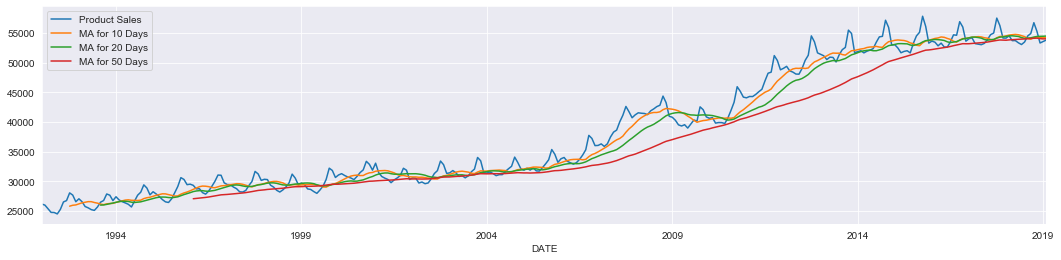

In [5]:
ma_day = [10,20,50]

for ma in ma_day:
    column_names = 'MA for %s Days'%str(ma)
    df[column_names] = df['Product Sales'].rolling(window=ma).mean()

df[['Product Sales','MA for 10 Days','MA for 20 Days','MA for 50 Days']].plot(figsize=(18,4));

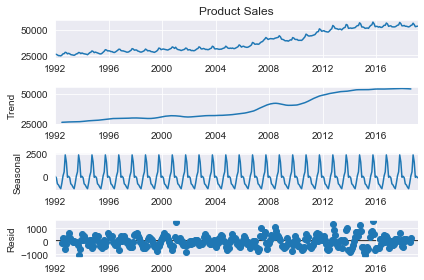

In [6]:
# ETS Decomposition

results = seasonal_decompose(df['Product Sales'])
results.plot();

In [7]:
# Dickey-Fuller Test for stationarity

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    
    print(out.to_string())    # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
        
    else:
        print('Weak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')

In [8]:
adf_test(df['Product Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.415517
p-value                   0.907475
# lags used              16.000000
# observations          309.000000
critical value (1%)      -3.451691
critical value (5%)      -2.870939
critical value (10%)     -2.571778
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


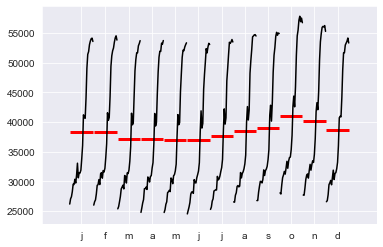

In [9]:
month_plot(df['Product Sales']);

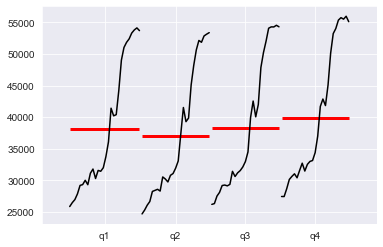

In [10]:
dfq = df['Product Sales'].resample(rule='Q').mean()
quarter_plot(dfq);

### ARIMA

In [11]:
stepwise_fit = auto_arima(df['Product Sales'], start_p=0, max_p=4, 
                          start_q=0, max_q=4, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5376.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5373.947, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5372.030, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5376.969, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5360.978, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5358.509, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5357.099, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5358.726, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5360.376, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5358.359, Time=0.02 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.527 seconds


In [12]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  326
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -2674.549
Date:                Mon, 15 Nov 2021   AIC                           5357.099
Time:                        10:33:12   BIC                           5372.234
Sample:                             0   HQIC                          5363.139
                                - 326                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     88.0356     61.262      1.437      0.151     -32.036     208.107
ma.L1          0.1669      0.036      4.687      0.000       0.097       0.237
ma.L2         -0.2060      0.037     -5.517      0.000      -0.279      -0.133
sigma2       8.17e+05   5.46e+04     14.976      0.000     7.1e+05    9.24e+05
===================================================================================
Ljung-Box (Q):                      911.86   Jarque-Bera (JB):                39.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data

In [13]:
len(df)

326

In [14]:
train, test = df.iloc[:314], df.iloc[314:]

In [15]:
train_values = train['Product Sales'].values
test_values = test['Product Sales'].values

history = [x for x in train_values]
predictions = list()

for t in range(len(test_values)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_values[t]
    history.append(obs)
    print("predicted = %f, expected = %f" % (yhat, obs))

predicted = 54737.317075, expected = 53707.000000
predicted = 53499.185957, expected = 53722.000000
predicted = 54130.296467, expected = 53341.000000
predicted = 53170.652046, expected = 53053.000000
predicted = 53307.405887, expected = 53482.000000
predicted = 53642.477811, expected = 54491.000000
predicted = 54752.985664, expected = 54913.000000
predicted = 54829.080078, expected = 56732.000000
predicted = 57280.275647, expected = 55272.000000
predicted = 54401.942001, expected = 53313.000000
predicted = 53645.154701, expected = 53569.000000
predicted = 53909.314100, expected = 53807.000000


In [16]:
error = np.sqrt(mean_squared_error(test_values, predictions))
print('Testing RMSE: %.3f' % error)

Testing RMSE: 973.843


In [17]:
test['Product Sales'].mean()

54116.833333333336

In [18]:
test['predictions'] = predictions
test

,Product Sales,MA for 10 Days,MA for 20 Days,MA for 50 Days,predictions
DATE,,,,,
2018-03-01,53707.0,54711.9,54523.35,53870.44,[54737.31707452311]
2018-04-01,53722.0,54758.7,54475.30,53904.74,[53499.185957410395]
2018-05-01,53341.0,54703.1,54411.55,53938.64,[54130.296466938395]
2018-06-01,53053.0,54536.5,54219.05,53961.06,[53170.65204644822]
2018-07-01,53482.0,54385.8,54093.10,53988.64,[53307.40588719936]
2018-08-01,54491.0,54084.2,54136.85,54031.18,[53642.477810863435]
2018-09-01,54913.0,53950.9,54181.35,54060.78,[54752.98566432595]
2018-10-01,56732.0,54209.4,54309.50,54108.58,[54829.08007828773]
2018-11-01,55272.0,54323.2,54412.95,54125.34,[57280.27564670381]


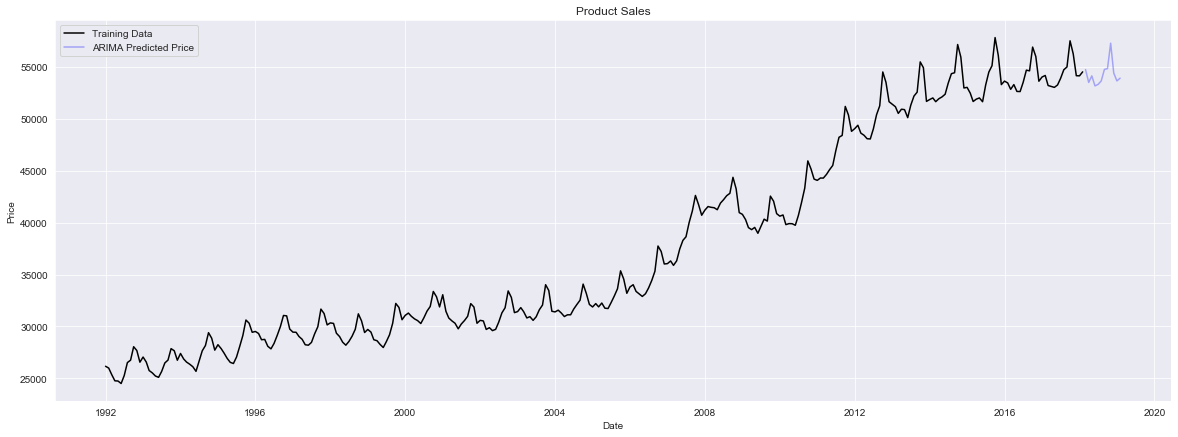

In [19]:
plt.figure(figsize=(20,7))
plt.title('Product Sales')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Product Sales'], 'black', label='Training Data')
plt.plot(test['predictions'], 'blue', alpha = 0.3, label = 'ARIMA Predicted Price')
plt.legend();

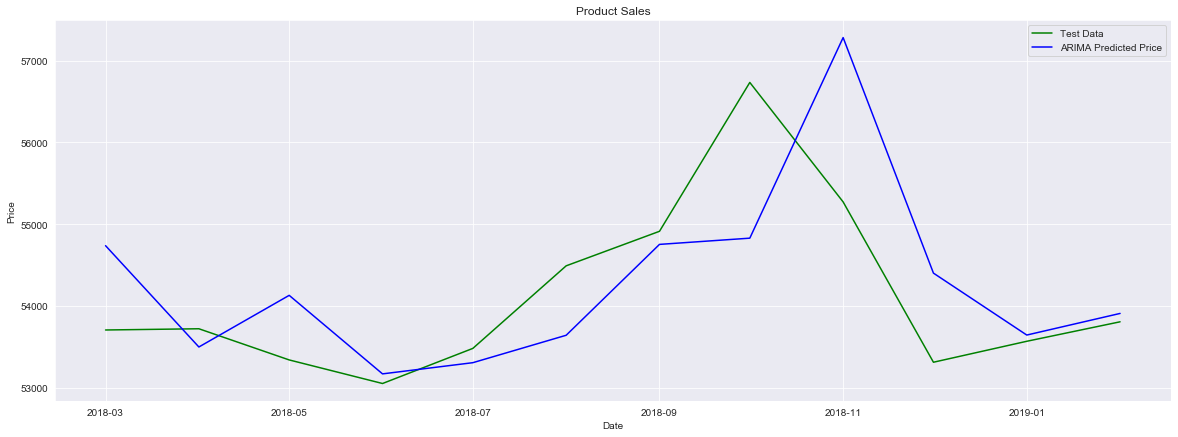

In [20]:
plt.figure(figsize=(20,7))
plt.title('Product Sales')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(test['Product Sales'], 'green', label = 'Test Data')
plt.plot(test['predictions'], 'blue', label = 'ARIMA Predicted Price')
plt.legend();

### Retrain the model on full data and forecast to the future

In [21]:
model = ARIMA(df['Product Sales'], order=(0,1,2))
results = model.fit()

fcast = results.predict(len(df), len(df)+11, typ='levels').rename('ARIMA Forecast')

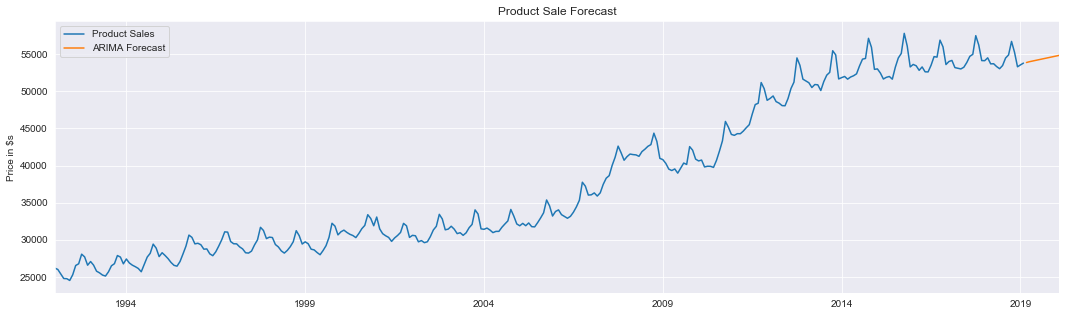

In [22]:
title = 'Product Sale Forecast'
ylabel = 'Price in $s'
xlabel = ''

ax = df['Product Sales'].plot(legend=True, figsize=(18,5), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

___

### SARIMAX

In [23]:
stepwise_fit = auto_arima(df['Product Sales'], start_p=0, max_p=4, 
                          start_q=0, max_q=4, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4920.220, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5376.320, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5009.084, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5206.825, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5376.969, Time=0.00 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5209.723, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5011.544, Time=0.29 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=4919.269, Time=1.99 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=4945.249, Time=1.32 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=5016.448, Time=2.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4970.628, Time=2.71 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=3.47 sec
 ARIMA(0,1,0)(2,0,1)[12]          

In [24]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  326
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2444.924
Date:                            Mon, 15 Nov 2021   AIC                           4897.848
Time:                                    10:34:01   BIC                           4912.983
Sample:                                         0   HQIC                          4903.889
                                            - 326                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0889      0.032      2.791      0.005       0.026       0.151
ar.S.L12       0.9625      0.010     95.677      0.000       0.943       0.982
ma.S.L12      -0.6930      0.038    -18.029      0.000      -0.768      -0.618
sigma2      1.436e+05   7839.697     18.314      0.000    1.28e+05    1.59e+05
===================================================================================
Ljung-Box (Q):                       89.66   Jarque-Bera (JB):               159.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.65
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data

In [25]:
train_1, test_1 = df.iloc[:314], df.iloc[314:]

In [26]:
train_values_1 = train_1['Product Sales'].values
test_values_1 = test_1['Product Sales'].values

history = [x for x in train_values_1]
predictions_1 = list()

for t in range(len(test_values_1)):
    model = SARIMAX(history, order=(0,1,1), seasonal_order=(1,0,1,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_1.append(yhat)
    obs = test_values_1[t]
    history.append(obs)
    print("predicted = %f, expected = %f" % (yhat, obs))

predicted = 53934.255467, expected = 53707.000000
predicted = 53829.740088, expected = 53722.000000
predicted = 53601.002941, expected = 53341.000000
predicted = 53318.528991, expected = 53053.000000
predicted = 53878.808840, expected = 53482.000000
predicted = 54341.845062, expected = 54491.000000
predicted = 54765.805600, expected = 54913.000000
predicted = 57178.660709, expected = 56732.000000
predicted = 55705.377403, expected = 55272.000000
predicted = 53175.884794, expected = 53313.000000
predicted = 53452.797505, expected = 53569.000000
predicted = 53652.249188, expected = 53807.000000


In [27]:
error_1 = np.sqrt(mean_squared_error(test_values_1, predictions_1))
print('Testing RMSE: %.3f' % error_1)

Testing RMSE: 265.566


In [28]:
test_1['Product Sales'].mean()

54116.833333333336

In [29]:
test_1['predictions'] = predictions_1
test_1

,Product Sales,MA for 10 Days,MA for 20 Days,MA for 50 Days,predictions
DATE,,,,,
2018-03-01,53707.0,54711.9,54523.35,53870.44,53934.255467
2018-04-01,53722.0,54758.7,54475.30,53904.74,53829.740088
2018-05-01,53341.0,54703.1,54411.55,53938.64,53601.002941
2018-06-01,53053.0,54536.5,54219.05,53961.06,53318.528991
2018-07-01,53482.0,54385.8,54093.10,53988.64,53878.808840
2018-08-01,54491.0,54084.2,54136.85,54031.18,54341.845062
2018-09-01,54913.0,53950.9,54181.35,54060.78,54765.805600
2018-10-01,56732.0,54209.4,54309.50,54108.58,57178.660709
2018-11-01,55272.0,54323.2,54412.95,54125.34,55705.377403


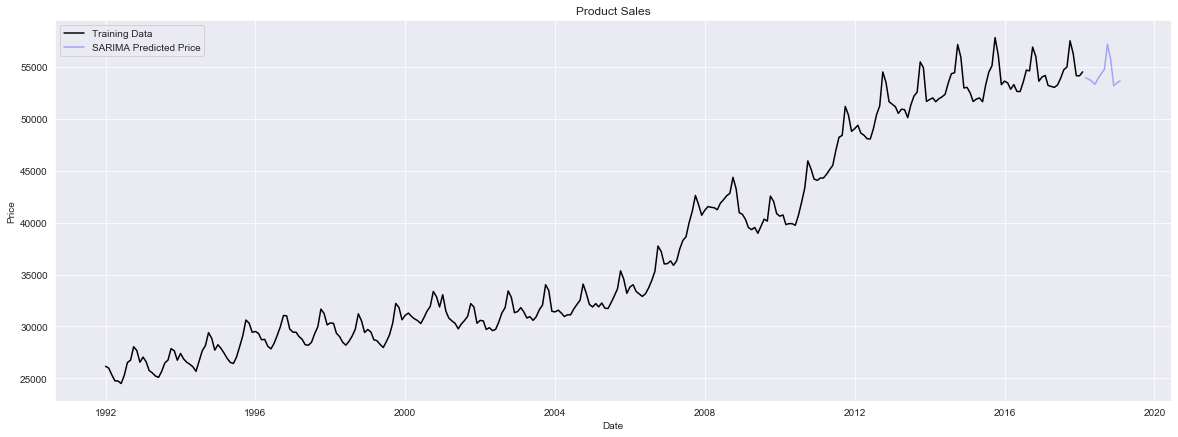

In [30]:
plt.figure(figsize=(20,7))
plt.title('Product Sales')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_1['Product Sales'], 'black', label='Training Data')
plt.plot(test_1['predictions'], 'blue', alpha = 0.3, label = 'SARIMA Predicted Price')
plt.legend();

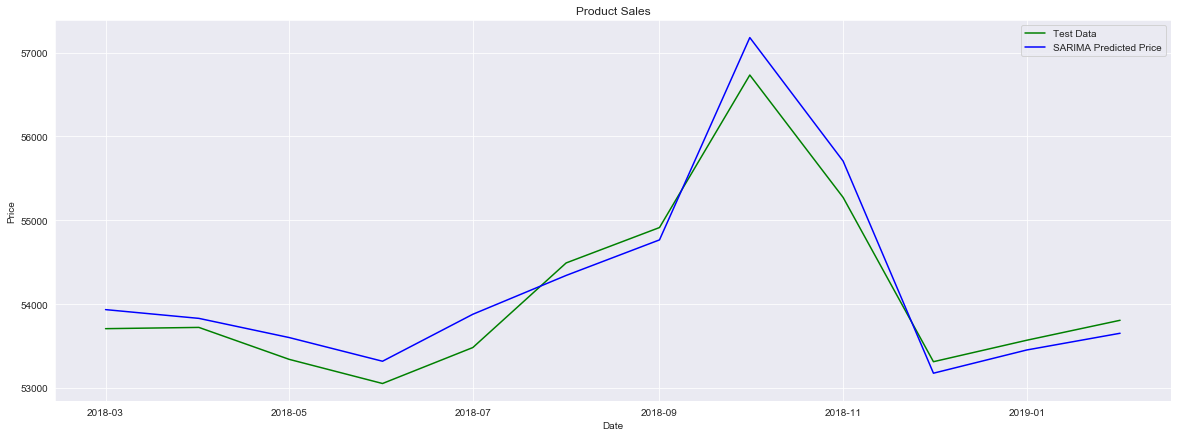

In [31]:
plt.figure(figsize=(20,7))
plt.title('Product Sales')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(test_1['Product Sales'], 'green', label = 'Test Data')
plt.plot(test_1['predictions'], 'blue', label = 'SARIMA Predicted Price')
plt.legend();

### Retrain the model on full data and forecast to the future

In [32]:
model = SARIMAX(df['Product Sales'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()

fcast = results.predict(len(df), len(df)+11, typ='levels').rename('SARIMA Forecast')

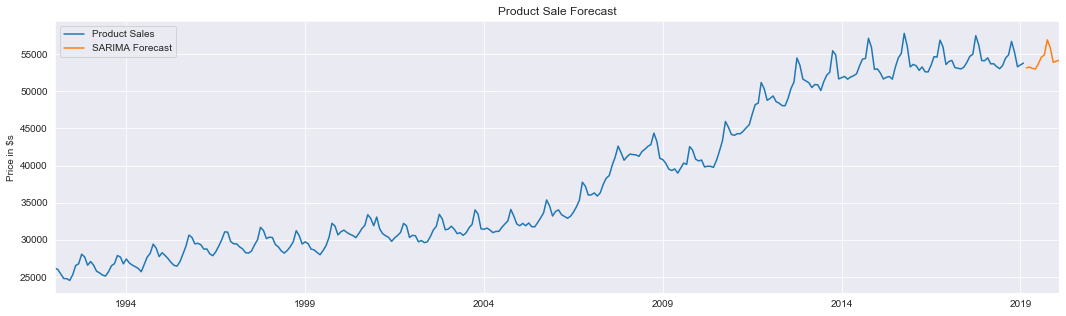

In [33]:
title = 'Product Sale Forecast'
ylabel = 'Price in $s'
xlabel = ''

ax = df['Product Sales'].plot(legend=True, figsize=(18,5), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

___
# Prophet

In [34]:
from fbprophet import Prophet

In [35]:
df = pd.read_csv('/Users/yossiarviv/Desktop/Datasets/Food_Products_Value.csv', parse_dates=True)
df.index.freq = 'MS'
df

,DATE,U11STI
0,1992-01-01,26169.0
1,1992-02-01,25992.0
2,1992-03-01,25367.0
3,1992-04-01,24766.0
4,1992-05-01,24749.0
...,...,...
321,2018-10-01,56732.0
322,2018-11-01,55272.0
323,2018-12-01,53313.0
324,2019-01-01,53569.0


In [36]:
# check the date type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 2 columns):
DATE      326 non-null object
U11STI    326 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.2+ KB


In [37]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1992-01-01,26169.0
1,1992-02-01,25992.0
2,1992-03-01,25367.0
3,1992-04-01,24766.0
4,1992-05-01,24749.0


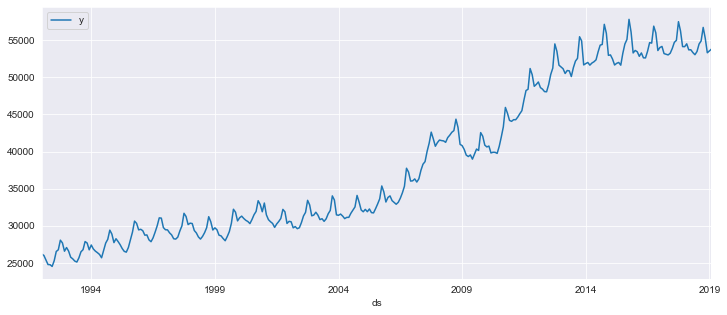

In [38]:
pd.plotting.register_matplotlib_converters()
df.plot(x='ds',y='y',figsize=(12,5)).autoscale(axis='x', tight=True);

### split the data

In [39]:
len(df)

326

In [40]:
train, test = df.iloc[:314], df.iloc[314:]

In [41]:
# create the model
m = Prophet().fit(train)

# step 1 - create a "future" placeholder dataframe.
# NOTE - prophet by default is for daily data. you need to pass a frequency for sub-daily or monthly data.
# for more info: https://facebook.github.io/prophet/docs/non-daily_data.html
future = m.make_future_dataframe(periods=12, freq='MS')

# step 2 - predict and fill in the future
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
321,2018-10-01,55532.149703,56909.350070,58714.083318,55351.640456,55672.012903,2280.410966,2280.410966,2280.410966,2280.410966,2280.410966,2280.410966,0.0,0.0,0.0,57812.560668
322,2018-11-01,55583.970869,56059.039022,57965.938178,55365.213016,55770.317933,1437.013651,1437.013651,1437.013651,1437.013651,1437.013651,1437.013651,0.0,0.0,0.0,57020.984520
323,2018-12-01,55634.120385,54534.889837,56433.420139,55369.763256,55875.435700,-210.547569,-210.547569,-210.547569,-210.547569,-210.547569,-210.547569,0.0,0.0,0.0,55423.572816
324,2019-01-01,55685.941552,54701.164421,56610.025632,55366.758035,55982.834231,-29.198386,-29.198386,-29.198386,-29.198386,-29.198386,-29.198386,0.0,0.0,0.0,55656.743166
325,2019-02-01,55737.762718,54664.450774,56702.002370,55379.079632,56098.290239,-89.554373,-89.554373,-89.554373,-89.554373,-89.554373,-89.554373,0.0,0.0,0.0,55648.208346


In [43]:
test.tail()

,ds,y
321,2018-10-01,56732.0
322,2018-11-01,55272.0
323,2018-12-01,53313.0
324,2019-01-01,53569.0
325,2019-02-01,53807.0


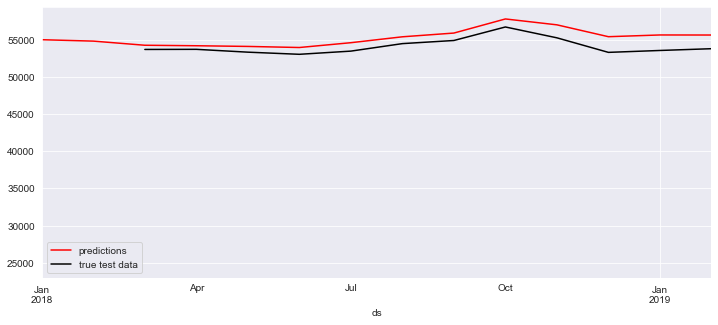

In [44]:
ax = forecast.plot(x='ds', y='yhat', label='predictions',legend=True, figsize=(12,5),color='red')
test.plot(x='ds', y='y', label='true test data', legend=True, ax=ax, xlim=('2018-01-01','2019-02-01'),color='black');

In [45]:
# Evaluation

from statsmodels.tools.eval_measures import rmse

predictions = forecast.iloc[-12:]['yhat']
predictions

314    54272.069244
315    54204.968645
316    54113.781085
317    53967.821351
318    54614.890036
319    55409.355690
320    55913.372682
321    57812.560668
322    57020.984520
323    55423.572816
324    55656.743166
325    55648.208346
Name: yhat, dtype: float64

In [46]:
test['y']

314    53707.0
315    53722.0
316    53341.0
317    53053.0
318    53482.0
319    54491.0
320    54913.0
321    56732.0
322    55272.0
323    53313.0
324    53569.0
325    53807.0
Name: y, dtype: float64

In [47]:
rmse(predictions,test['y'])

1339.900764346809

In [48]:
test.mean()

y    54116.833333
dtype: float64

In [49]:
# Prophet built-in Diagnostics

from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [50]:
# when running cross validation metric, we need to define 3 things:
# 1. initial training period
# 2. the period length that we're going to perform cross validation for
# 3. the horizon of period for each fold

# Inintial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'

# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'

# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

# IT HAS TO BE IN THIS EXACT FORMAT

In [51]:
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Making 5 forecasts with cutoffs between 1997-02-06 00:00:00 and 2017-02-01 00:00:00


In [52]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1997-03-01,28906.141275,28722.305306,29101.537839,29037.0,1997-02-06
1,1997-04-01,28579.297806,28384.947481,28765.980164,28764.0,1997-02-06
2,1997-05-01,28225.675664,28031.429725,28434.085513,28241.0,1997-02-06
3,1997-06-01,27939.112205,27711.167099,28159.436738,28197.0,1997-02-06
4,1997-07-01,28576.474047,28357.622868,28823.215523,28467.0,1997-02-06


In [53]:
performance_metrics(df_cv)

# this tells us for each horizon period, what the stats or evaluation metrics are.
# mape = mean absolute percentage error

,horizon,mse,rmse,mae,mape,coverage
0,54 days,1.193884e+06,1092.650048,916.686946,0.022408,0.333333
1,55 days,1.217277e+06,1103.302920,961.017422,0.023870,0.333333
2,56 days,1.553211e+06,1246.278904,1093.069861,0.026612,0.333333
3,58 days,1.860177e+06,1363.882919,1199.775808,0.027473,0.333333
4,59 days,1.820977e+06,1349.435838,1187.588302,0.026766,0.333333
5,84 days,1.422794e+06,1192.809493,932.518041,0.022014,0.500000
6,85 days,1.430764e+06,1196.145405,949.440315,0.022556,0.500000
7,86 days,2.903346e+06,1703.920771,1383.104908,0.033684,0.333333
8,88 days,2.933711e+06,1712.807998,1392.062206,0.031998,0.333333
9,89 days,2.788394e+06,1669.848611,1347.329835,0.030628,0.333333


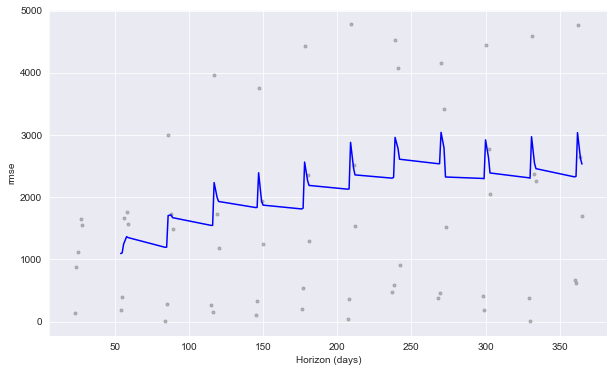

In [54]:
# Cross Validation Plot

plot_cross_validation_metric(df_cv, metric='rmse');

### Retrain the model on full data and forecast to the future

In [55]:
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
333,2019-10-01,55091.471978,56535.654416,58300.678262,54909.823915,55240.752706,2346.989834,2346.989834,2346.989834,2346.989834,2346.989834,2346.989834,0.0,0.0,0.0,57438.461812
334,2019-11-01,55121.948900,55590.493621,57374.167458,54895.756857,55321.796606,1397.994378,1397.994378,1397.994378,1397.994378,1397.994378,1397.994378,0.0,0.0,0.0,56519.943278
335,2019-12-01,55151.442695,54035.361858,55808.828087,54873.122806,55393.380949,-258.268941,-258.268941,-258.268941,-258.268941,-258.268941,-258.268941,0.0,0.0,0.0,54893.173753
336,2020-01-01,55181.919616,54197.700355,56140.975340,54825.807436,55476.849133,1.686981,1.686981,1.686981,1.686981,1.686981,1.686981,0.0,0.0,0.0,55183.606597
337,2020-02-01,55212.396537,54329.335847,56299.461118,54798.131673,55565.768709,117.653466,117.653466,117.653466,117.653466,117.653466,117.653466,0.0,0.0,0.0,55330.050003


In [57]:
df.tail()

,ds,y
321,2018-10-01,56732.0
322,2018-11-01,55272.0
323,2018-12-01,53313.0
324,2019-01-01,53569.0
325,2019-02-01,53807.0


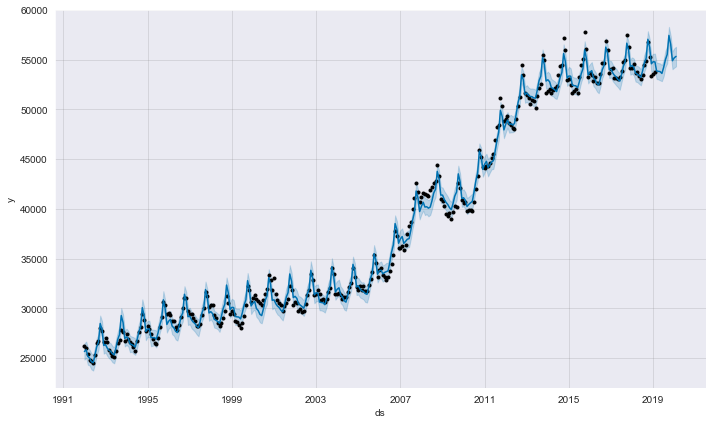

In [58]:
m.plot(forecast);

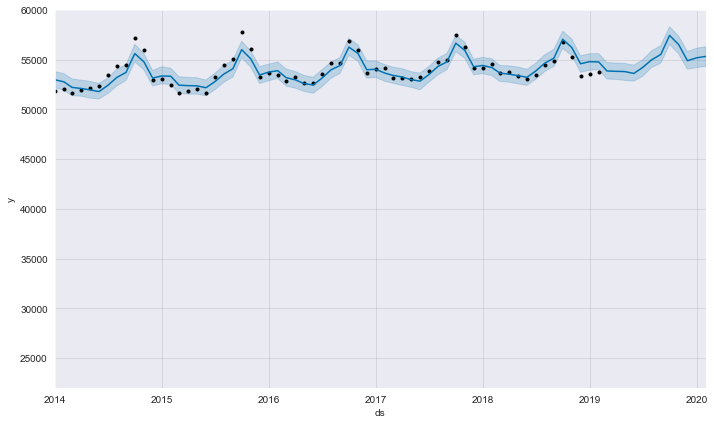

In [59]:
m.plot(forecast);
plt.xlim('2014-01-01', '2020-02-01');